<a href="https://colab.research.google.com/github/nikhil550000/Sentiment-Analysis-using-LSTM/blob/main/Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer

from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,classification_report
warnings.filterwarnings('ignore')


In [37]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
train_data = pd.read_csv('dataset/train.csv',encoding='latin1');
test_data = pd.read_csv('dataset/test.csv',encoding='latin1');

In [39]:
df = pd.concat([train_data,test_data])


In [40]:
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


In [42]:
def remove_unnecessary_characters(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text
df['clean_text'] = df['text'].apply(remove_unnecessary_characters)

In [43]:
def tokenize_text(text):
    try:
        text = str(text)
        tokens = word_tokenize(text)
        return tokens
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        return []

df['tokens'] = df['text'].apply(tokenize_text)

In [44]:
def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text
df['normalized_text'] = df['text'].apply(normalize_text)

In [45]:
df.dropna(inplace = True)

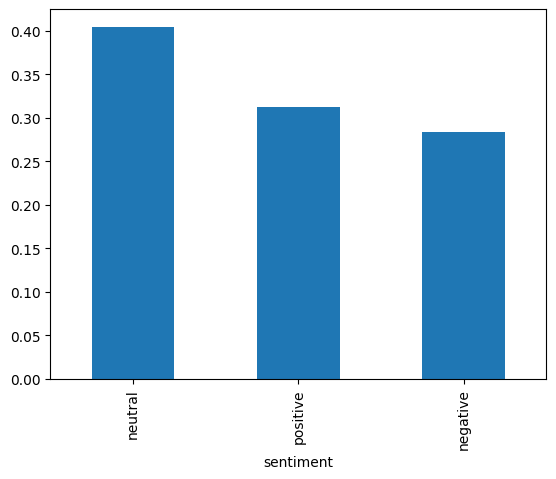

In [46]:
df['sentiment'].value_counts(normalize = True).plot(kind = 'bar');

In [47]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


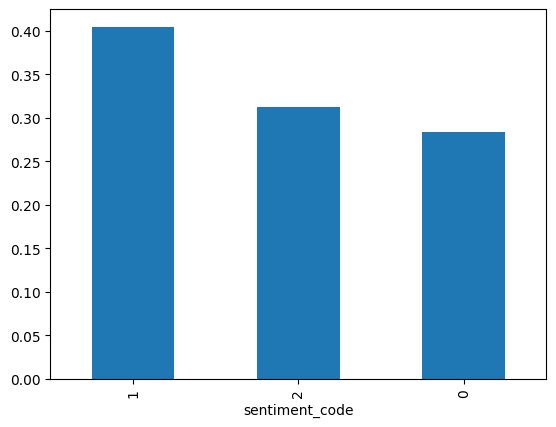

In [48]:
df['sentiment_code'] = df['sentiment'].astype('category').cat.codes
sentiment_distribution = df['sentiment_code'].value_counts(normalize=True)
sentiment_distribution.plot(kind='bar')
plt.show()

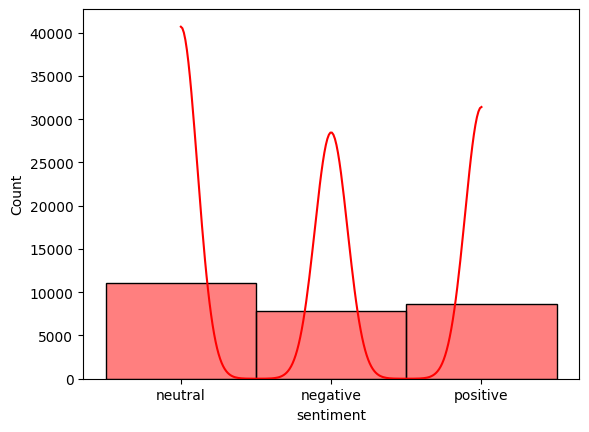

In [49]:
sns.histplot(df['sentiment'], kde=True, color = 'r')
plt.show()

In [50]:
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()
corpus = df['text'].tolist()
print(len(corpus))
print(corpus[0])

27480
 I`d have responded, if I were going


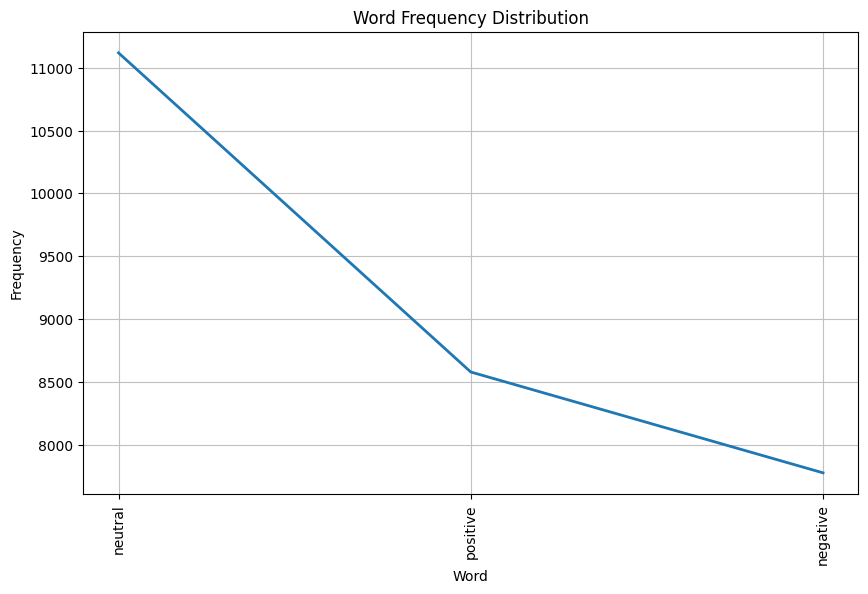

In [51]:
from nltk.probability import FreqDist
word_freq = FreqDist(word_tokenize(' '.join(df['sentiment'])))
plt.figure(figsize=(10, 6))
word_freq.plot(20, cumulative=False)
plt.title('Word Frequency Distribution')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

In [52]:
final_corpus = df['text'].astype(str).tolist()
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df["sentiment"].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [53]:
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
df['Country'] = df['Country'].astype('category').cat.codes
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

In [54]:
df=df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

In [55]:
import string
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['selected_text'] = df["selected_text"].apply(wp)

In [56]:
df

,text,selected_text,sentiment,clean_text,tokens,normalized_text,sentiment_code
0,"I`d have responded, if I were going",Id have responded if I were going,neutral,Id have responded if I were going,"[I, `, d, have, responded, ,, if, I, were, going]",id have responded if i were going,1
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego,"[Sooo, SAD, I, will, miss, you, here, in, San,...",sooo sad i will miss you here in san diego,0
2,my boss is bullying me...,bullying me,negative,my boss is bullying me,"[my, boss, is, bullying, me, ...]",my boss is bullying me,0
3,what interview! leave me alone,leave me alone,negative,what interview leave me alone,"[what, interview, !, leave, me, alone]",what interview leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",Sons of,negative,Sons of why couldnt they put them on the relea...,"[Sons, of, *, *, *, *, ,, why, couldn, `, t, t...",sons of why couldnt they put them on the relea...,0
...,...,...,...,...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see u on Denver husband los...,"[wish, we, could, come, see, u, on, Denver, hu...",wish we could come see u on denver husband los...,0
27477,I`ve wondered about rake to. The client has ...,dont force,negative,Ive wondered about rake to The client has made...,"[I, `, ve, wondered, about, rake, to, ., The, ...",ive wondered about rake to the client has made...,0
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you,positive,Yay good for both of you Enjoy the break you p...,"[Yay, good, for, both, of, you, ., Enjoy, the,...",yay good for both of you enjoy the break you p...,2
27479,But it was worth it ****.,But it was worth it,positive,But it was worth it,"[But, it, was, worth, it, *, *, *, *, .]",but it was worth it,2


In [57]:
X=df['selected_text']
y= df['sentiment']


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform(X_train)
XV_test = vectorization.transform(X_test)

# Model Building

In [60]:
# Prepare the data
class SentimentDataset(Dataset):
  def __init__(self,X,y):
    self.X = torch.tensor(X.toarray(),dtype=torch.float32)
    self.y = torch.tensor(y.values,dtype=torch.long)


  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [61]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## Create datasets and dataloaders
train_dataset = SentimentDataset(XV_train,pd.Series(y_train_encoded))
test_dataset = SentimentDataset(XV_test,pd.Series(y_test_encoded))


train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [62]:
# Define the RNN Model
class SentimentRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(SentimentRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        _, (hidden, _) = self.rnn(x.unsqueeze(1))  # Adding batch-first compatibility
        out = self.fc(hidden[-1])  # Take the last hidden state
        return out


# Model parameters
input_dim = XV_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model = SentimentRNN(input_dim,hidden_dim,output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)



In [64]:
# Training the model
epochs = 10
for epoch in range(epochs):
  model.train()
  total_loss = 0
  for X_batch,y_batch in train_dataloader:
    optimizer.zero_grad()
    output = model(X_batch)
    loss = criterion(output,y_batch)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader):.4f}")



Epoch 1/5, Loss: 0.3480
Epoch 2/5, Loss: 0.2443
Epoch 3/5, Loss: 0.1908
Epoch 4/5, Loss: 0.1609
Epoch 5/5, Loss: 0.1430


In [65]:

# Evaluate the model
model.eval()
all_preds , all_labels = [],[]
with torch.no_grad():
  for X_batch,y_batch in test_dataloader:
    output = model(X_batch)
    preds = torch.argmax(output,dim=1)
    all_preds.extend(preds.tolist())
    all_labels.extend(y_batch.tolist())

accuracy = accuracy_score(all_labels,all_preds)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8077
